# Final training

Now we will work on how to run to train the different models in order to obtain the one with the best results and opitmize it's parameters to have the best model with the best parameters

To do so we will follow the next logic:

* From the subset of all models, we will select the ones with the following characteristics and train all of them
  * The ones with maximum interpretability
  * The ones with lowest inference

* To optimize their parameters, we will run two possible approaches main approaches
  * Model weights
    * Gradient Descent, automatically used in scikit-learn 
  * Hyper parameters
    * Random Search, in a small enough set, not small enough to try them all, is plausible to find an optimal set of hyperparameters with early stopping
    * Bayesian Approach, use probabilities to find the most suitable set of hyperparameters

Gradient Descent and similars do not work in discrete values (hyperparameters) since a continous function is needed in order to differentiate.

In this notebook we will work on the assumption that we have already pre-processed all the data, and reduced it's dimentionality and we receive as input a matrix X containing all ECGs + demographic data and a matrix Y containing the final labels of the train, and we can divide them between train and test accordingly.

The following cell is just some fictional data in order to facilitate the final code


In [21]:
## TODO Tot això és un exemple de codi per generar dades sintètiques, s'en va a la caca quan fem merge amb les dades reals

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Parameters for synthetic data
n_samples = 500
n_ecg_features = 100  # e.g., ECG_0, ECG_1, ..., ECG_99

# Create synthetic numeric columns
np.random.seed(42)
df = pd.DataFrame({
    'Height': np.random.normal(170, 10, n_samples),
    'Weight': np.random.normal(70, 15, n_samples),
    'BMI': np.random.normal(24, 4, n_samples),
})

# Add synthetic ECG features
for i in range(n_ecg_features):
    df[f'ECG_{i}'] = np.random.normal(0, 1, n_samples)

# Add categorical/boolean columns
df['Gender'] = np.random.choice(['Male', 'Female'], n_samples)
df['Smoker'] = np.random.choice(['Yes', 'No'], n_samples)
df['HTA'] = np.random.choice(['Yes', 'No'], n_samples)
df['DM'] = np.random.choice(['Yes', 'No'], n_samples)
df['DLP'] = np.random.choice(['Yes', 'No'], n_samples)
df['COPD'] = np.random.choice(['Yes', 'No'], n_samples)
df['Sleep_apnea'] = np.random.choice(['Yes', 'No'], n_samples)

# Add a binary label column
df['Label'] = np.random.choice([0, 1], n_samples)

# Now proceed as before
Y = df['Label'].values

numeric_cols = ['Height', 'Weight', 'BMI'] + [col for col in df.columns if col.startswith('ECG_')]
X_numeric = df[numeric_cols].copy()

scaler = MinMaxScaler()
X_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns, index=X_numeric.index)

categorical_cols = ['Gender', 'Smoker', 'HTA', 'DM', 'DLP', 'COPD', 'Sleep_apnea']
X_categorical = df[categorical_cols].copy()
X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

X = pd.concat([X_numeric_scaled, X_categorical_encoded], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (400, 110)
X_test shape: (100, 110)
Y_train shape: (400,)
Y_test shape: (100,)


/tmp/ipykernel_1138/1105765671.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'ECG_{i}'] = np.random.normal(0, 1, n_samples)
/tmp/ipykernel_1138/1105765671.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Gender'] = np.random.choice(['Male', 'Female'], n_samples)
/tmp/ipykernel_1138/1105765671.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

Now that we have expressed the idea behind, let's define the subset of models we have chosen

In [22]:
from sklearn.linear_model    import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes     import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from imodels                 import RuleFitClassifier   
from sklearn.neighbors       import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid

# Here we have defined the subset of models we discussed have previosuly discussed, 
# they are the ones with highest interpretability and lowest inference time.

models = {
    "logreg": LogisticRegression(solver="saga", max_iter=5_000),
    "lda":    LinearDiscriminantAnalysis(),
    "gnb":    GaussianNB(),
    "mnb":    MultinomialNB(),
    "bnb":    BernoulliNB(),
    "dt":     DecisionTreeClassifier(),
    "rf":     RandomForestClassifier(),
    "rulefit": RuleFitClassifier(),
    "knn":    KNeighborsClassifier(),
    "rnn":    RadiusNeighborsClassifier(),
    "nc":     NearestCentroid(),
}

The search of optimal parameters is done inside the same loop of trainig, now we procideed whit the three best mentioned approaches, from which we will keep the most suitable 

# Brute Force parameter approach

Here we can set up the first original idea, that is of trying all different parameters using brute force, `GridSearchCV` does exactly that, from a list of possible parameters tries them all and chooses the best one.

We can do that if we pre-define the set of possible parameters, leaving a small space for the possible combination of parameters, making it possible to try them all in a plausible computational time.
(The parameters set can be enlarged, but be aware, that the computational time has an exponential relationship with the number of parameters, since it tries al possible combinations)

In [23]:
# Here we define the hyperparameter grids for each model.
# Since we work with exautive search, we can expand the list to try more pausible hyperparameters.

param_grids = {
    "logreg": {
        "penalty": ["l1","l2","elasticnet"],
        "C":       [0.01, 0.1, 1, 10],
        "l1_ratio":[0.0, 0.5, 1.0],  
    },
    "lda": {
        "solver":   ["svd","lsqr","eigen"],
        "shrinkage":[None, 0.1, 0.5, 1.0],
    },
    "gnb": {"var_smoothing": np.logspace(-9, -6, 5)},
    "mnb": {"alpha": [0.1, 0.5, 1.0]},
    "bnb": {"alpha": [0.1, 0.5, 1.0]},
    "dt": {
        "max_depth":        [3,5,10,None],
        "min_samples_leaf": [1,5,10]
    },
    "rf": {
        "n_estimators": [50,100,200],
        "max_depth":    [5,10,None],
        "max_features": ["auto","sqrt","log2"]
    },
    "rulefit": {
        "max_rules":        [10, 20, 50],
        "tree_size":        [3, 5, 7]
    },
    "knn": {
        "n_neighbors": [3,5,10],
        "weights":     ["uniform","distance"],
        "p":           [1,2]
    },
    "rnn": {
        "radius":       [0.5, 1.0, 2.0],                 
        "outlier_label":[ "most_frequent", 0, 1 ],     
        "weights":      [ "uniform", "distance" ]       
    },
    "nc":  {"shrink_threshold": [None, 0.0, 0.1]}
}


In [24]:
from sklearn.metrics import roc_auc_score, accuracy_score

# This function is used to safely score a model on the test set, since the models are different on how they return predictions, we need to handle them differently.
# TODO el try and except soc concient de que no és la millor manera de fer-ho, però per sake of simplicity i que no es trenqui el codi, ho deixem així (per ara).

def safe_score(estimator, X_test, y_test):
    """
    Return ROC-AUC if we can get continuous scores, else fall
    back to accuracy on hard predictions. Catches both ValueError
    and AttributeError so no model can crash us.
    """
    try:
        # Prefer probabilities
        if hasattr(estimator, "predict_proba"):
            probs = estimator.predict_proba(X_test)[:, 1]
            return roc_auc_score(y_test, probs)
        
        # Next, decision_function if available
        if hasattr(estimator, "decision_function"):
            scores = estimator.decision_function(X_test)
            return roc_auc_score(y_test, scores)
        
        # Finally, fall back to hard predictions → accuracy
        preds = estimator.predict(X_test)
        return accuracy_score(y_test, preds)
    
    except (ValueError, AttributeError) as e:
        print(f"⚠️  Warning scoring {estimator.__class__.__name__}: {e}")
        return float("nan")



from sklearn.model_selection import GridSearchCV

# This function performs hyperparameter tuning and evaluation for a given model, we will loop over it for the models

def train_and_evaluate(model_name,
                       model,
                       param_grid,
                       X_train, y_train,
                       X_test,  y_test,
                       cv=5,
                       scoring="roc_auc"):
    # 1) Hyper‐parameter search
    search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    search.fit(X_train, y_train)
    
    best = search.best_estimator_
    
    # 2) Safe test‐set scoring
    test_score = safe_score(best, X_test, y_test)
    
    return {
        "model":       model_name,
        "best_params": search.best_params_,
        "cv_score":    search.best_score_,
        "test_score":  test_score,
        "estimator":   best
    }



In [25]:
# Here we itereate over the models and perform hyperparameter tuning and evaluation.

results = []

"""for name, mdl in models.items():
    print(f"\n=== Training: {name} ===")
    print(mdl)
    print(f"\n=== Tuning & evaluating: {name} ===")
    grid = param_grids.get(name, {})  # empty dict → no tuning, just default
    res  = train_and_evaluate(name, mdl, grid,
                              X_train, Y_train,
                              X_test,  Y_test,
                              cv=5, scoring="roc_auc")
    results.append(res)"""



'for name, mdl in models.items():\n    print(f"\n=== Training: {name} ===")\n    print(mdl)\n    print(f"\n=== Tuning & evaluating: {name} ===")\n    grid = param_grids.get(name, {})  # empty dict → no tuning, just default\n    res  = train_and_evaluate(name, mdl, grid,\n                              X_train, Y_train,\n                              X_test,  Y_test,\n                              cv=5, scoring="roc_auc")\n    results.append(res)'

In [26]:
# Train and evaluate Logistic Regression
name = "logreg"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: logreg ===
LogisticRegression(max_iter=5000, solver='saga')

=== Tuning & evaluating: logreg ===
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio pa

In [27]:
# Train and evaluate Linear Discriminant Analysis
name = "lda"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: lda ===
LinearDiscriminantAnalysis()

=== Tuning & evaluating: lda ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/discrimina

In [28]:
# Train and evaluate Gaussian Naive Bayes
name = "gnb"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: gnb ===
GaussianNB()

=== Tuning & evaluating: gnb ===
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [29]:
# Train and evaluate Multinomial Naive Bayes
name = "mnb"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: mnb ===
MultinomialNB()

=== Tuning & evaluating: mnb ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [30]:
# Train and evaluate Bernoulli Naive Bayes
name = "bnb"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: bnb ===
BernoulliNB()

=== Tuning & evaluating: bnb ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [31]:
# Train and evaluate Decision Tree Classifier
name = "dt"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: dt ===
DecisionTreeClassifier()

=== Tuning & evaluating: dt ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [32]:
# Train and evaluate Random Forest
name = "rf"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: rf ===
RandomForestClassifier()

=== Tuning & evaluating: rf ===
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/base.py", line 638, in _va

In [34]:
# Train and evaluate RuleFit Classifier
name = "rulefit"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: rulefit ===
RuleFitClassifier(max_rules=30)

=== Tuning & evaluating: rulefit ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [35]:
# Train and evaluate K-Nearest Neighbors
name = "knn"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: knn ===
KNeighborsClassifier()

=== Tuning & evaluating: knn ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [36]:
# Train and evaluate Radius Neighbors Classifier
name = "rnn"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: rnn ===
RadiusNeighborsClassifier()

=== Tuning & evaluating: rnn ===
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [37]:
# Train and evaluate Nearest Centroid
name = "nc"
mdl = models[name]
print(f"\n=== Training: {name} ===")
print(mdl)
print(f"\n=== Tuning & evaluating: {name} ===")
grid = param_grids.get(name, {})
res = train_and_evaluate(name, mdl, grid,
                         X_train, Y_train,
                         X_test, Y_test,
                         cv=5, scoring="roc_auc")
results.append(res)


=== Training: nc ===
NearestCentroid()

=== Tuning & evaluating: nc ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 459, in _score
    y_pred = method_caller(clf, "decision_function", X, pos_label=pos_label)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/utils/_response.py", line 181, in _get_response_values
    prediction_method = _check_response_method(estimator, response_method)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/utils/validation.py", line 1939, in _check_response_method
    rai

In [38]:
# Sort by test performance
results = sorted(results, key=lambda r: r["test_score"], reverse=True)

In [39]:

## TODO funció auxiliar per a plotar la matriu de confusió
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion(estimator, X_test, y_test, labels=None, title=None):
    """
    Fits nothing (assumes estimator is already trained),
    predicts on X_test and plots the confusion matrix.
    """
    y_pred = estimator.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(cmap="Blues")
    if title:
        plt.title(title)
    plt.show()

# Suppose `results` is the list of dicts you returned from your train_with_* functions:
# [{'model':'logreg', 'estimator':clf1, ...}, {'model':'rf', 'estimator':clf2, ...}, ...]

# And you have your test split: X_test, y_test
# Optionally collect the unique labels in your problem:


gnb         Test AUC: 0.572  CV AUC: 0.502
  Params: {'var_smoothing': 1e-09}


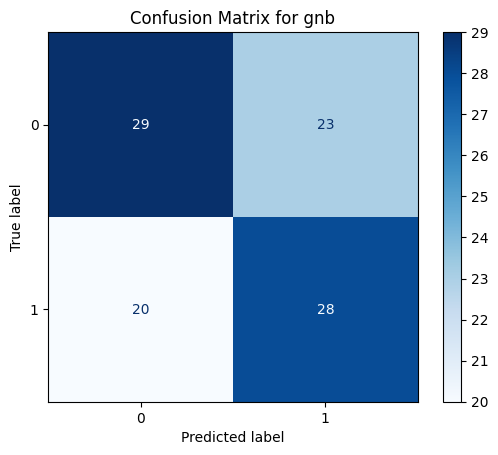

rf          Test AUC: 0.520  CV AUC: 0.537
  Params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}


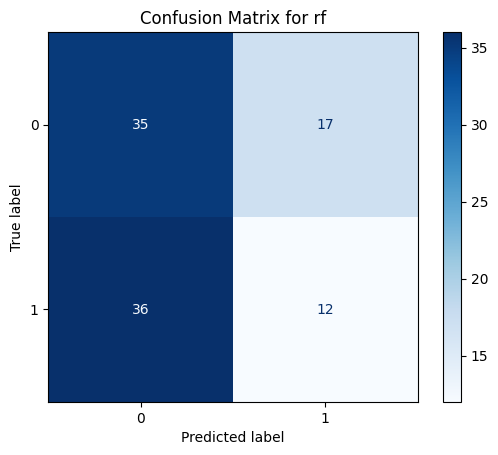

mnb         Test AUC: 0.505  CV AUC: 0.453
  Params: {'alpha': 0.1}


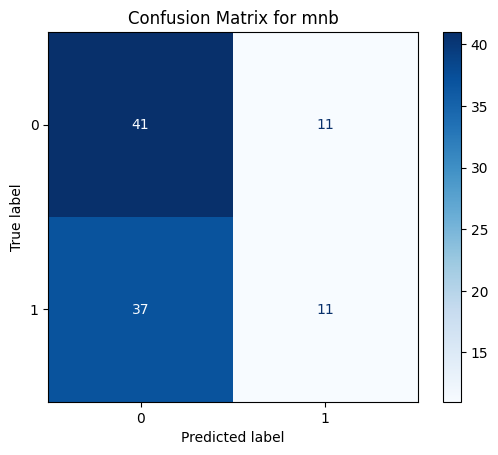

In [40]:
# Show top 3
for top in results[:3]:
    print(f"{top['model']:10s}  Test AUC: {top['test_score']:.3f}  CV AUC: {top['cv_score']:.3f}")
    print("  Params:", top["best_params"])
    plot_confusion(top["estimator"], X_test, Y_test, labels=[0, 1], title=f"Confusion Matrix for {top['model']}")

# Randomized approach

Why RandomizedSearch?

When your hyper-parameter space is large (many parameters, each with multiple possible values), exhaustive Grid Search becomes prohibitively expensive (combinatorial explosion).

RandomizedSearchCV lets you specify a total budget (n_iter) of trials. It samples parameter combinations at random, often finding nearly optimal settings in far fewer trials.

It is important to notice that the randomized search does not ensure an optimal solution, but the set of parameters can be longer. We can work with continuous sets, rather than discretes as before

In [41]:
from scipy.stats import loguniform, randint, uniform

param_dists = {
    "logreg": {
        "penalty":   ["l1", "l2", "elasticnet"],
        "C":         loguniform(1e-3, 1e1),   
        "l1_ratio":  uniform(0, 1)              
    },
    "lda": {
        "solver":    ["svd", "lsqr", "eigen"],
        "shrinkage": uniform(0, 1)              
    },
    "gnb": {
        "var_smoothing": loguniform(1e-12, 1e-6)
    },
    "mnb": {
        "alpha": loguniform(1e-2, 10)          
    },
    "bnb": {
        "alpha": loguniform(1e-2, 10)
    },
    "dt": {
        "max_depth":        randint(1, 20),    
        "min_samples_leaf": randint(1, 20),
        "criterion":        ["gini", "entropy"]
    },
    "rf": {
        "n_estimators": randint(50, 300),
        "max_depth":    randint(3, 20),
        "max_features": ["auto", "sqrt", "log2"]
    },
    "rulefit": {
        "max_rules": randint(5, 100),
        "tree_size": randint(2, 10)
    },
    "knn": {
        "n_neighbors": randint(1, 30),
        "weights":     ["uniform", "distance"],
        "p":           [1, 2]                  
    },
    "rnn": {
        "radius":       uniform(0.1, 5.0),      
        "weights":      ["uniform", "distance"],
        "outlier_label": ["most_frequent", 0, 1]
    },
    "nc": {
        "shrink_threshold": uniform(0, 1)       
    }
}


In [42]:
from sklearn.model_selection import RandomizedSearchCV

# As before, we set a function to perform hyperparameter tuning and evaluation, but this time using RandomizedSearchCV for efficiency.

def train_with_random_search(model_name,
                             model,
                             param_dist,
                             X_train, y_train,
                             X_test,  y_test,
                             cv=5,
                             scoring="roc_auc",
                             n_iter=50,         # we can expand the number of iterations to explore more hyperparameter combinations
                             random_state=42):
    """
    1) Runs RandomizedSearchCV on (model, param_dist)
    2) Refits best model on full X_train
    3) Scores on X_test via safe_score
    """
    search = RandomizedSearchCV(
        estimator     = model,
        param_distributions = param_dist,
        n_iter        = n_iter,
        cv            = cv,
        scoring       = scoring,
        n_jobs        = -1,
        verbose       = 1,
        refit         = True,
        random_state  = random_state
    )
    search.fit(X_train, y_train)
    
    best = search.best_estimator_
    test_score = safe_score(best, X_test, y_test)
    
    return {
        "model":       model_name,
        "best_params": search.best_params_,
        "cv_score":    search.best_score_,
        "test_score":  test_score,
        "estimator":   best
    }


In [43]:
# As before, we iterate over the models and perform hyperparameter tuning and evaluation, but this time using RandomizedSearchCV.

results = []

"""for name, mdl in models.items():
    print(f"\n>>> Random search for: {name}")
    dist = param_dists.get(name, {})
    res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
    results.append(res)

# Filter out failures and sort by test score
results = [r for r in results if not np.isnan(r["test_score"])]
results.sort(key=lambda r: r["test_score"], reverse=True)"""



'for name, mdl in models.items():\n    print(f"\n>>> Random search for: {name}")\n    dist = param_dists.get(name, {})\n    res = train_with_random_search(name, mdl, dist,\n                                       X_train, Y_train, X_test, Y_test,\n                                       cv=5, scoring="roc_auc",\n                                       n_iter=50, random_state=42)\n    results.append(res)\n\n# Filter out failures and sort by test score\nresults = [r for r in results if not np.isnan(r["test_score"])]\nresults.sort(key=lambda r: r["test_score"], reverse=True)'

In [44]:
# Train and evaluate Logistic Regression with Random Search
name = "logreg"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: logreg
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio pa

In [45]:
# Train and evaluate Linear Discriminant Analysis with Random Search
name = "lda"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: lda
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/discrimin

In [46]:
# Train and evaluate Gauss Naive Bayes with Random Search
name = "gnb"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: gnb
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [47]:
# Train and evaluate Multinomial Naive Bayes with Random Search
name = "mnb"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: mnb
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [48]:
# Train and evaluate Bernoulli Naive Bayes with Random Search
name = "bnb"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: bnb
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [49]:
# Train and evaluate Decision Tree Classifier with Random Search
name = "dt"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: dt
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [50]:
# Train and evaluate Random Forest with Random Search
name = "rf"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: rf
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/base.py", line 638, in _va

In [51]:
# Train and evaluate RuleFit Classifier with Random Search
name = "rulefit"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: rulefit
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [52]:
# Train and evaluate K-Nearest Neighbors with Random Search
name = "knn"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: knn
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [53]:
# Train and evaluate Radius Neighbors Classifier with Random Search
name = "rnn"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: rnn
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [54]:
# Train and evaluate Logistic Nearest Centroid with Random Search
name = "nc"
mdl = models[name]
print(f"\n>>> Random search for: {name}")
dist = param_dists.get(name, {})
res = train_with_random_search(name, mdl, dist,
                                       X_train, Y_train, X_test, Y_test,
                                       cv=5, scoring="roc_auc",
                                       n_iter=50, random_state=42)
results.append(res)


>>> Random search for: nc
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 459, in _score
    y_pred = method_caller(clf, "decision_function", X, pos_label=pos_label)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/utils/_response.py", line 181, in _get_response_values
    prediction_method = _check_response_method(estimator, response_method)
  File "/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/utils/validation.py", line 1939, in _check_response_method
    rai

In [55]:
results = [r for r in results if not np.isnan(r["test_score"])]
results.sort(key=lambda r: r["test_score"], reverse=True)

gnb         Test AUC: 0.572  Params: {'var_smoothing': 1.7670169402947945e-10}


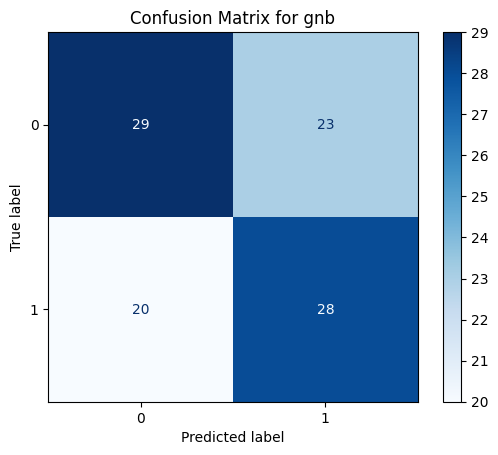

dt          Test AUC: 0.554  Params: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 13}


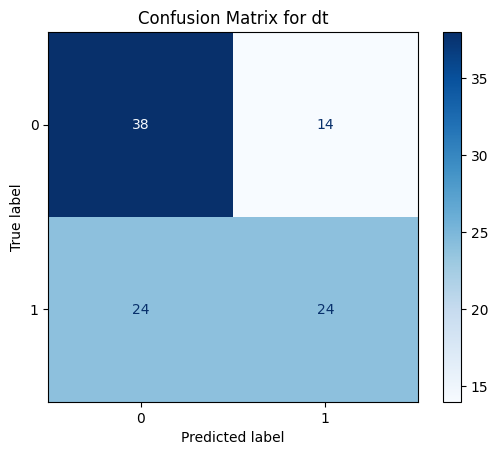

rf          Test AUC: 0.552  Params: {'max_depth': 14, 'max_features': 'log2', 'n_estimators': 293}


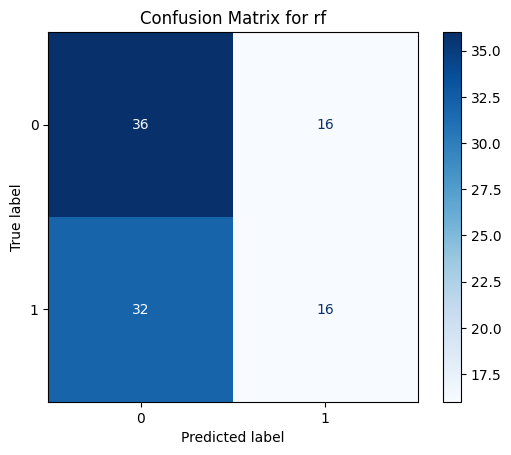

In [56]:
for top in results[:3]:
    print(f"{top['model']:10s}  Test AUC: {top['test_score']:.3f}  Params: {top['best_params']}")
    plot_confusion(top["estimator"], X_test, Y_test, labels=[0, 1], title=f"Confusion Matrix for {top['model']}")


# Bayesian optimization

When model training is expensive and evaluations are limited, traditional methods like grid or random search can be wasteful. Bayesian Optimization builds a probabilistic model of the objective function and uses it to intelligently choose the most promising hyper-parameters to evaluate next.

It is particularly useful when each model evaluation is costly, and you want to make the most out of every iteration. It aims not only to explore the space but also to exploit known good regions by balancing performance and uncertainty.

It is important to notice that Bayesian Optimization does not guarantee a globally optimal solution, but it tends to find strong results in fewer evaluations. It also works well with continuous, discrete, or categorical parameters.

In [57]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

search_spaces = {
    "logreg": {
        "penalty":  Categorical(["l1","l2","elasticnet"]),
        "C":        Real(1e-3, 1e1, prior="log-uniform"),
        "l1_ratio": Real(0.0, 1.0)
    },
    "lda": [
        {
            "solver":    Categorical(["svd"]),
            "shrinkage": Categorical([None])
        },
        {
            "solver":    Categorical(["lsqr","eigen"]),
            "shrinkage": Real(0.0, 1.0)
        }
    ],
    "gnb": {
        "var_smoothing": Real(1e-12, 1e-6, prior="log-uniform")
    },
    "mnb": {
        "alpha": Real(1e-2,  10.0, prior="log-uniform")
    },
    "bnb": {
        "alpha": Real(1e-2,  10.0, prior="log-uniform")
    },
    "dt": {
        "max_depth":        Integer(1, 20),
        "min_samples_leaf": Integer(1, 20),
        "criterion":        Categorical(["gini","entropy"])
    },
    "rf": {
        "n_estimators": Integer(50, 300),
        "max_depth":    Integer(3, 20),
        "max_features": Categorical(["sqrt", "log2", None])
    },
    "rulefit": {
        "max_rules": Integer(5, 100),
        "tree_size": Integer(2, 10)
    },
    "knn": {
        "n_neighbors": Integer(1, 30),
        "weights":     Categorical(["uniform","distance"]),
        "p":           Integer(1,2)
    },
    "rnn": {
        "radius":        Real(0.1, 5.0),
        "weights":       Categorical(["uniform","distance"]),
        "outlier_label": Categorical(["most_frequent",0,1])
    },
    "nc": {
        "shrink_threshold": Real(1e-6, 1.0)
    }
}


In [58]:
def train_with_bayes_search(name, estimator, param_space,
                            X_train, y_train, X_test, y_test,
                            cv=5, n_iter=30, scoring=None):
    """
    1) BayesSearchCV over param_space (n_iter trials)
    2) Refit best on all X_train
    3) Safe‐score on X_test
    """

    # Some models do not allow for probabilties using predict_proba (nc)
    # or decision_function, so we need to set a default scoring
    if scoring is None:
        if hasattr(estimator, "predict_proba") or hasattr(estimator, "decision_function"):
            scoring = "roc_auc"
        else:
            scoring = "accuracy"

    bayes = BayesSearchCV(
        estimator=estimator,
        search_spaces=param_space,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    bayes.fit(X_train, y_train)
    best = bayes.best_estimator_
    test_score = safe_score(best, X_test, y_test)

    return {
        "name": name,
        "estimator": best,
        "test_score": test_score,
        "cv_score": bayes.best_score_,
        "scoring": scoring
    }


In [59]:
# And as before, we iterate over the models and perform hyperparameter tuning and evaluation, but this time using BayesSearchCV.

results = []

"""for name, mdl in models.items():
    print(f"\n>>> Bayesian tuning for: {name}")
    space = search_spaces.get(name, {})
    res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

    results.append(res)

# Filter out any NaN & sort by test performance
results = [r for r in results if not np.isnan(r["test_score"])]
results.sort(key=lambda r: r["test_score"], reverse=True)"""




'for name, mdl in models.items():\n    print(f"\n>>> Bayesian tuning for: {name}")\n    space = search_spaces.get(name, {})\n    res = train_with_bayes_search(name, mdl, space,\n                                      X_train, Y_train, X_test, Y_test,\n                                      cv=5, n_iter=30)\n\n    results.append(res)\n\n# Filter out any NaN & sort by test performance\nresults = [r for r in results if not np.isnan(r["test_score"])]\nresults.sort(key=lambda r: r["test_score"], reverse=True)'

In [60]:
# Train and evaluate Logistic Regression with Bayesian Tuning

name = "logreg"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: logreg


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio pa

In [61]:
# Train and evaluate Linear Discriminant Analysis with Bayesian Tuning

name = "lda"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: lda


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'svd'] before, using random point [None, 'svd']
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'svd'] before, using random point [None, 'svd']
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'svd'] before, using random point [None, 'svd']
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'svd'] before, using random point [None, 'svd']
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/skopt/optimizer/

In [62]:
# Train and evaluate Gaussian Naive Bayes with Bayesian Tuning

name = "gnb"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: gnb


/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0032119327384744e-12] before, using random point [7.950671924212018e-07]
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.001640519016334e-12] before, using random point [1.1854610211962299e-09]
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0032460950772888e-12] before, using random point [1.4957678401349267e-11]
  warnings.warn(
/home/marc/miniconda3/envs/CompBioMed25/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0004939304812889e-12] before, using random point [4.348183902561162e-12]
  warnings.warn(

In [63]:
# Train and evaluate Multinomial Naive Bayes with Bayesian Tuning

name = "mnb"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: mnb


In [64]:
# Train and evaluate Bernoulli Naive Bayes with Bayesian Tuning

name = "bnb"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: bnb


In [65]:
# Train and evaluate Decision Tree Classifier with Bayesian Tuning

name = "dt"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: dt


In [66]:
# Train and evaluate Random Forest with Bayesian Tuning

name = "rf"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: rf


In [67]:
# Train and evaluate RuleFit Classifier with Bayesian Tuning

name = "rulefit"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: rulefit


In [68]:
# Train and evaluate K-Nearest Neighbors with Bayesian Tuning

name = "knn"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: knn


In [69]:
# Train and evaluate Radius Neighbors Classifier with Bayesian Tuning

name = "rnn"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: rnn


In [70]:
# Train and evaluate Nearest Centroid with Bayesian Tuning

name = "nc"
mdl = models[name]
print(f"\n>>> Bayesian tuning for: {name}")
space = search_spaces.get(name, {})
res = train_with_bayes_search(name, mdl, space,
                                      X_train, Y_train, X_test, Y_test,
                                      cv=5, n_iter=30)

results.append(res)


>>> Bayesian tuning for: nc


In [71]:
results = [r for r in results if not np.isnan(r["test_score"])]
results.sort(key=lambda r: r["test_score"], reverse=True)

gnb         Test AUC: 0.572
 Params: GaussianNB(var_smoothing=2.1940165663471486e-09)


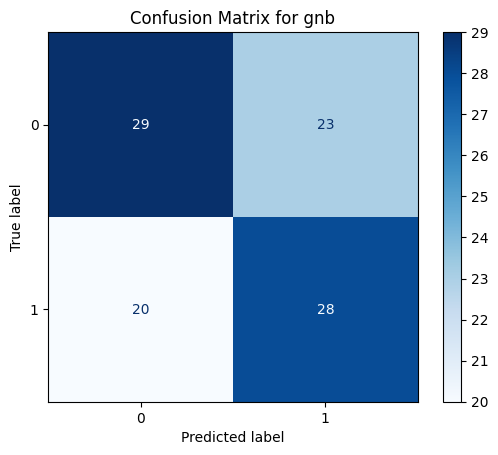

dt          Test AUC: 0.553
 Params: DecisionTreeClassifier(criterion='entropy', max_depth=16, min_samples_leaf=13)


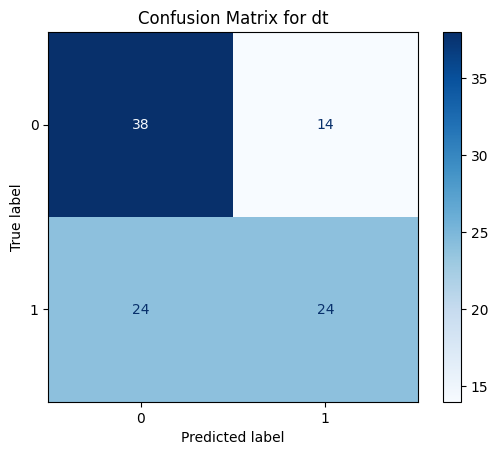

rf          Test AUC: 0.522
 Params: RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=194)


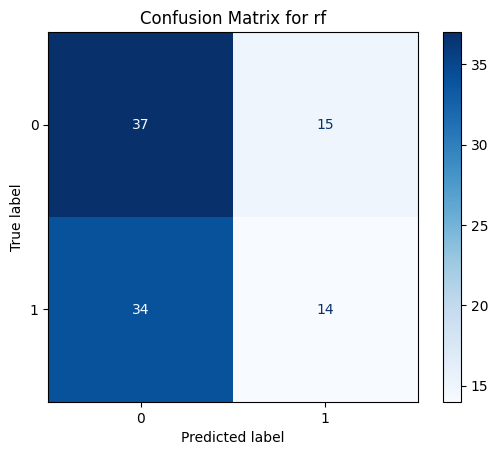

In [72]:
# Display top performers
for top in results[:3]:
    print(f"{top['name']:10s}  Test AUC: {top['test_score']:.3f}")
    print(" Params:", top["estimator"])
    plot_confusion(top["estimator"], X_test, Y_test, labels=[0, 1], title=f"Confusion Matrix for {top['name']}")

In [73]:
for top in results:
    print(f"{top['name']:10s}  Test AUC: {top['test_score']:.3f}")
    print(" Params:", top["estimator"])

gnb         Test AUC: 0.572
 Params: GaussianNB(var_smoothing=2.1940165663471486e-09)
dt          Test AUC: 0.553
 Params: DecisionTreeClassifier(criterion='entropy', max_depth=16, min_samples_leaf=13)
rf          Test AUC: 0.522
 Params: RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=194)
lda         Test AUC: 0.517
 Params: LinearDiscriminantAnalysis(shrinkage=0.39484454851669054, solver='eigen')
rnn         Test AUC: 0.509
 Params: RadiusNeighborsClassifier(outlier_label=1, radius=1.9513220515379641,
                          weights='distance')
mnb         Test AUC: 0.505
 Params: MultinomialNB(alpha=9.99908176374054)
logreg      Test AUC: 0.500
 Params: LogisticRegression(C=0.0713688940948096, l1_ratio=0.8473314010216634,
                   max_iter=5000, penalty='l1', solver='saga')
bnb         Test AUC: 0.494
 Params: BernoulliNB(alpha=9.996890645053348)
knn         Test AUC: 0.494
 Params: KNeighborsClassifier(n_neighbors=18, p=1)
nc          Test AUC: 0